<a href="https://colab.research.google.com/github/Upeshjeengar/Deep-learning-Methods-in-Fluid-Dynamics/blob/main/wave_equation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Method 1


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Define the neural network architecture
class PINN(tf.keras.Model):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden_layers = [tf.keras.layers.Dense(20, activation='tanh') for _ in range(5)]
        self.output_layer = tf.keras.layers.Dense(1, activation=None)

    def call(self, inputs):
        x, t = inputs[:, 0:1], inputs[:, 1:2]
        u = tf.concat([x, t], axis=1)
        for layer in self.hidden_layers:
            u = layer(u)
        u = self.output_layer(u)
        return u

# Exact solution function
def exact_solution(x, t, N_terms=50):
    L = np.pi
    u = np.zeros_like(x)
    for n in range(1, N_terms + 1):
        if n % 2 == 0:
            continue  # Bn is zero for even n
        # Compute An and Bn
        if n == 1:
            An = 1  # Since A1 = 1
        else:
            An = 0  # An = 0 for n != 1
        Bn = (-4) / (n * np.pi**2 * (n**2 - 1))
        u += np.sin(n * x) * (An * np.cos(n * t) + Bn * np.sin(n * t))
    return u

# Loss function with corrections
def loss(model, X_f, X_i, X_b):
    # PDE Residual Loss
    x_f = X_f[:, 0:1]
    t_f = X_f[:, 1:2]

    with tf.GradientTape(persistent=True) as tape1:
        tape1.watch([x_f, t_f])
        with tf.GradientTape(persistent=True) as tape0:
            tape0.watch([x_f, t_f])
            u = model(tf.concat([x_f, t_f], axis=1))
        u_x = tape0.gradient(u, x_f)
        u_t = tape0.gradient(u, t_f)
    u_xx = tape1.gradient(u_x, x_f)
    u_tt = tape1.gradient(u_t, t_f)
    del tape0
    del tape1

    f = u_tt - u_xx

    # Initial Condition Loss
    x_i = X_i[:, 0:1]
    t_i = X_i[:, 1:2]  # This will be zeros

    with tf.GradientTape() as tape_ic:
        tape_ic.watch([x_i, t_i])
        u0 = model(tf.concat([x_i, t_i], axis=1))
    u0_t = tape_ic.gradient(u0, t_i)
    u0_exact = tf.sin(x_i)
    u0_t_exact = tf.cos(x_i)

    # Boundary Condition Loss
    x_b = X_b[:, 0:1]
    t_b = X_b[:, 1:2]
    ub = model(tf.concat([x_b, t_b], axis=1))
    ub_exact = tf.zeros_like(ub)

    # Loss components
    mse_f = tf.reduce_mean(tf.square(f))
    mse_u0 = tf.reduce_mean(tf.square(u0 - u0_exact))
    mse_u0_t = tf.reduce_mean(tf.square(u0_t - u0_t_exact))
    mse_ub = tf.reduce_mean(tf.square(ub - ub_exact))

    return mse_f + mse_u0 + mse_u0_t + mse_ub

# Domain boundaries
L = np.pi
T_max = 1.0

# Collocation points for PDE residual
N_f = 20000
x_f = np.random.uniform(0, L, (N_f, 1))
t_f = np.random.uniform(0, T_max, (N_f, 1))
X_f = np.hstack((x_f, t_f))

# Initial condition points
N_i = 2000
x_i = np.random.uniform(0, L, (N_i, 1))
t_i = np.zeros((N_i, 1))
X_i = np.hstack((x_i, t_i))

# Boundary condition points
N_b = 2000
t_b = np.random.uniform(0, T_max, (N_b, 1))
x_b0 = np.zeros((N_b, 1))
x_bL = L * np.ones((N_b, 1))
X_b = np.vstack((np.hstack((x_b0, t_b)), np.hstack((x_bL, t_b))))

# Convert to tensors
X_f_tf = tf.convert_to_tensor(X_f, dtype=tf.float32)
X_i_tf = tf.convert_to_tensor(X_i, dtype=tf.float32)
X_b_tf = tf.convert_to_tensor(X_b, dtype=tf.float32)

# Initialize the model
model = PINN()

# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Training loop
epochs = 5000

for epoch in range(epochs):
    with tf.GradientTape() as tape:
        current_loss = loss(model, X_f_tf, X_i_tf, X_b_tf)
    grads = tape.gradient(current_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    if epoch % 500 == 0:
        print(f'Epoch {epoch}, Loss: {current_loss.numpy()}')

# Generate grid for plotting
x_plot = np.linspace(0, L, 256)
t_plot = np.linspace(0, T_max, 100)
X, T = np.meshgrid(x_plot, t_plot)
X_plot = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))

# PINN prediction
u_pred = model.predict(X_plot).reshape(X.shape)

# Exact solution
u_exact = exact_solution(X, T)

# Plotting the results
# Plot PINN solution
fig = plt.figure(figsize=(12, 5))

ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(X, T, u_pred, cmap='viridis')
ax.set_title('PINN Solution')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u(x,t)')

# Plot Exact solution
ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X, T, u_exact, cmap='viridis')
ax.set_title('Exact Solution')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u(x,t)')

plt.show()

# Error Analysis
error = np.mean((u_pred - u_exact)**2)
print(f'Mean Squared Error between PINN and Exact Solution: {error}')

800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


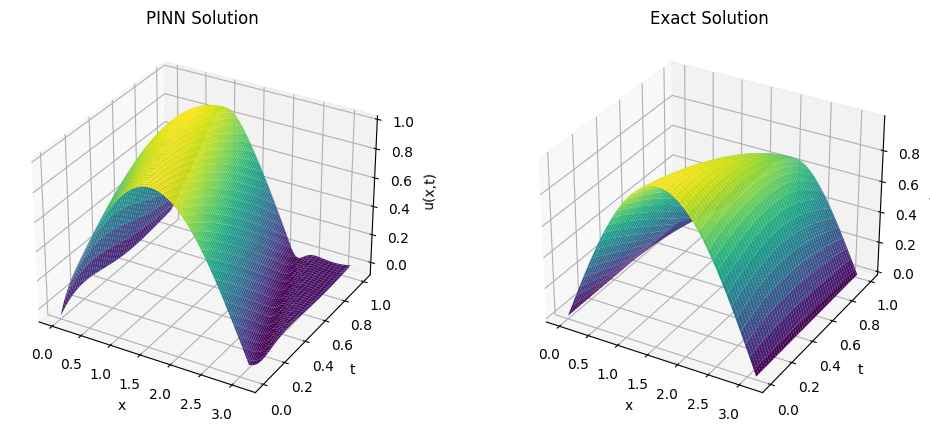

Mean Squared Error between PINN and Exact Solution: 0.12605917530471147


In [ ]:
import numpy as np

def exact_solution(x, t, N_terms=50):
    L = np.pi
    u = np.zeros_like(x)
    for n in range(1, N_terms + 1):
        # Compute An and Bn
        if n == 1:
            An = 1  # As calculated above
            Bn = 0  # Since Bn = 0 when n is odd
        elif n % 2 == 0:
            # n is even
            An = 0  # An = 0 for n != 1
            # Compute Bn for even n
            numerator = -2 * ((1) + 1)  # (-1)^n + 1 with n even is 2
            denominator = n * np.pi * ((n + 1) * (n - 1))
            Bn = numerator / denominator
        else:
            # n is odd and not 1
            An = 0
            Bn = 0  # Bn = 0 when n is odd
        # Compute u
        u += np.sin(n * x) * (An * np.cos(n * t) + Bn * np.sin(n * t))
    return u
# Generate grid for plotting
x_plot = np.linspace(0, L, 256)
t_plot = np.linspace(0, T_max, 100)
X, T = np.meshgrid(x_plot, t_plot)
X_plot = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))

# PINN prediction
u_pred = model.predict(X_plot).reshape(X.shape)

# Exact solution
u_exact = exact_solution(X, T)

# Plotting the results
# Plot PINN solution
fig = plt.figure(figsize=(12, 5))

ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(X, T, u_pred, cmap='viridis')
ax.set_title('PINN Solution')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u(x,t)')

# Plot Exact solution
ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X, T, u_exact, cmap='viridis')
ax.set_title('Exact Solution')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u(x,t)')

plt.show()

# Error Analysis
error = np.mean((u_pred - u_exact)**2)
print(f'Mean Squared Error between PINN and Exact Solution: {error}')

# Method 2

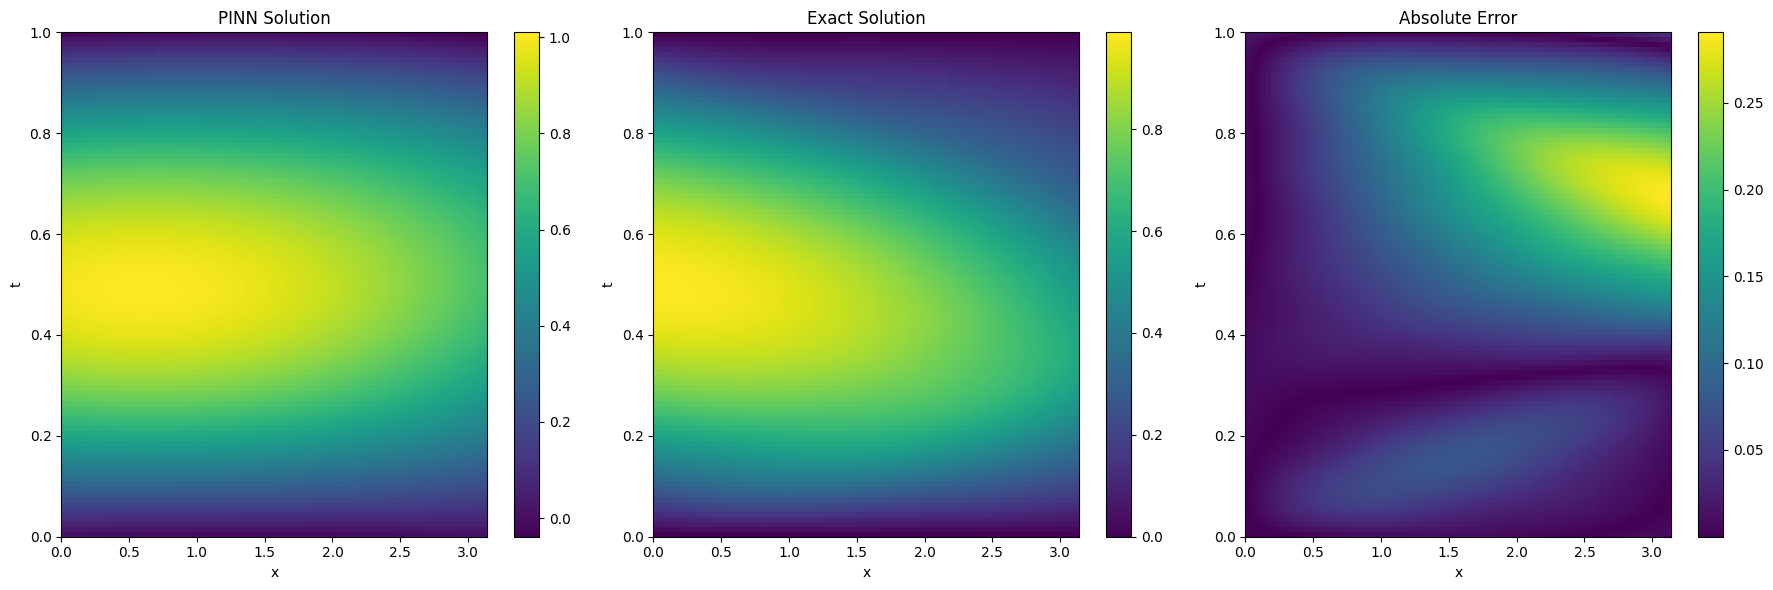

Mean Squared Error: 0.011408
Mean Absolute Error: 0.078297


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
tf.random.set_seed(1234)
np.random.seed(1234)

# Define constants
L = np.pi  # Length of the domain
c = 1.0    # Wave speed

# Define the neural network
def create_model():
    inputs = tf.keras.layers.Input(shape=(2,))
    x = tf.keras.layers.Dense(50, activation='tanh')(inputs)
    x = tf.keras.layers.Dense(50, activation='tanh')(x)
    x = tf.keras.layers.Dense(50, activation='tanh')(x)
    outputs = tf.keras.layers.Dense(1)(x)
    return tf.keras.Model(inputs=inputs, outputs=outputs)

# Define the loss function
@tf.function
def pde_loss(x, t):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([x, t])
        with tf.GradientTape(persistent=True) as tape2:
            tape2.watch([x, t])
            u = model(tf.stack([x, t], axis=1))
        u_x, u_t = tape2.gradient(u, [x, t])

    u_xx = tape.gradient(u_x, x)
    u_tt = tape.gradient(u_t, t)

    del tape, tape2  # Delete the tapes

    pde = u_tt - c**2 * u_xx
    return tf.reduce_mean(tf.square(pde))

@tf.function
def boundary_loss(x, t):
    u_0 = model(tf.stack([tf.zeros_like(x), t], axis=1))
    u_L = model(tf.stack([L * tf.ones_like(x), t], axis=1))
    return tf.reduce_mean(tf.square(u_0) + tf.square(u_L))

@tf.function
def initial_condition_loss(x):
    with tf.GradientTape() as tape:
        tape.watch(x)
        u_0 = model(tf.stack([x, tf.zeros_like(x)], axis=1))
    u_t_0 = tape.gradient(u_0, x)
    return tf.reduce_mean(tf.square(u_0 - tf.sin(x)) + tf.square(u_t_0 - tf.cos(x)))

# Create and compile the model
model = create_model()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Training loop
@tf.function
def train_step():
    x = tf.random.uniform((100, 1), 0, L)
    t = tf.random.uniform((100, 1), 0, 1)

    with tf.GradientTape() as tape:
        loss = pde_loss(x, t) + boundary_loss(x, t) + initial_condition_loss(x)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

epochs = 2000
for epoch in range(epochs):
    loss = train_step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.numpy():.4f}")

# Define the exact solution
def exact_solution(x, t, n_terms=10):
    x = tf.cast(x, tf.float32)
    t = tf.cast(t, tf.float32)

    def An(n):
        return 2/L * tf.reduce_sum(tf.sin(x) * tf.sin(n * np.pi * x / L)) * L / tf.cast(tf.size(x), tf.float32)

    def Bn(n):
        return 2/(n * np.pi * L) * tf.reduce_sum(tf.cos(x) * tf.sin(n * np.pi * x / L)) * L / tf.cast(tf.size(x), tf.float32)

    u = tf.zeros_like(x)
    for n in range(1, n_terms + 1):
        u += tf.sin(n * np.pi * x / L) * (An(n) * tf.cos(n * np.pi * t / L) + Bn(n) * tf.sin(n * np.pi * t / L))
    return u

# Generate points for comparison
x_test = np.linspace(0, L, 100)
t_test = np.linspace(0, 1, 100)
X, T = np.meshgrid(x_test, t_test)

# Predict using PINN
u_pred = model(np.stack([X.flatten(), T.flatten()], axis=-1)).numpy().reshape(X.shape)

# Calculate exact solution
u_exact = exact_solution(X, T).numpy()

# Plot results
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

im1 = ax1.imshow(u_pred.T, aspect='auto', extent=[0, L, 0, 1], origin='lower')
ax1.set_title("PINN Solution")
ax1.set_xlabel("x")
ax1.set_ylabel("t")
plt.colorbar(im1, ax=ax1)

im2 = ax2.imshow(u_exact.T, aspect='auto', extent=[0, L, 0, 1], origin='lower')
ax2.set_title("Exact Solution")
ax2.set_xlabel("x")
ax2.set_ylabel("t")
plt.colorbar(im2, ax=ax2)

im3 = ax3.imshow(np.abs(u_pred - u_exact).T, aspect='auto', extent=[0, L, 0, 1], origin='lower')
ax3.set_title("Absolute Error")
ax3.set_xlabel("x")
ax3.set_ylabel("t")
plt.colorbar(im3, ax=ax3)

plt.tight_layout()
plt.show()

# Print some statistics
mse = np.mean((u_pred - u_exact)**2)
mae = np.mean(np.abs(u_pred - u_exact))
print(f"Mean Squared Error: {mse:.6f}")
print(f"Mean Absolute Error: {mae:.6f}")